# Train DL model for object detection

In [1]:
# The following code refer to https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [2]:
# Test GPU availability:

import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-fe9sz3gs
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-fe9sz3gs
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=265174 sha256=314af38224b88bed1e785cd0d81589fbdfd08f4b8032c01edb29378b6dea9d10
  Stored in directory: /tmp/pip-ephem-wheel-cache-52iaklae/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.4
    Uninstalling pycocotools-2.0.4:
      Successfully uninstalled pycocotools-2.0.4


In [4]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 159768, done.
remote: Counting objects: 100% (4390/4390), done.
remote: Compressing objects: 100% (391/391), done.
remote: Total 159768 (delta 4037), reused 4279 (delta 3978), pack-reused 155378
Receiving objects: 100% (159768/159768), 315.81 MiB | 13.98 MiB/s, done.
Resolving deltas: 100% (141998/141998), done.
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)


In [5]:
#mount drive
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd ./content
!ls
%cp /mydrive/SEP769/sub_images.zip ./
%cp /mydrive/SEP769/sub_mask.zip ./
%cp /mydrive/SEP769/class_dict_seg.csv ./

/
Mounted at /content/gdrive
/content
coco_eval.py   engine.py  sample_data	 utils.py
coco_utils.py  gdrive	  transforms.py  vision


In [6]:
# Unzip the SatData in the current folder:
%%shell

unzip sub_images.zip
unzip sub_mask.zip

Archive:  sub_images.zip
   creating: sub_images/
  inflating: sub_images/016.jpg      
  inflating: __MACOSX/sub_images/._016.jpg  
  inflating: sub_images/002.jpg      
  inflating: __MACOSX/sub_images/._002.jpg  
  inflating: sub_images/003.jpg      
  inflating: __MACOSX/sub_images/._003.jpg  
  inflating: sub_images/149.jpg      
  inflating: __MACOSX/sub_images/._149.jpg  
  inflating: sub_images/001.jpg      
  inflating: __MACOSX/sub_images/._001.jpg  
  inflating: sub_images/015.jpg      
  inflating: __MACOSX/sub_images/._015.jpg  
  inflating: sub_images/014.jpg      
  inflating: __MACOSX/sub_images/._014.jpg  
  inflating: sub_images/000.jpg      
  inflating: __MACOSX/sub_images/._000.jpg  
  inflating: sub_images/028.jpg      
  inflating: __MACOSX/sub_images/._028.jpg  
  inflating: sub_images/148.jpg      
  inflating: __MACOSX/sub_images/._148.jpg  
  inflating: sub_images/004.jpg      
  inflating: __MACOSX/sub_images/._004.jpg  
  inflating: sub_images/038.jpg      

In [7]:
from pathlib import Path
Path("./SegDataset").mkdir(parents=True, exist_ok=True)

In [8]:
! mv ./sub_images ./SegDataset/
! mv ./sub_mask ./SegDataset/

In [9]:
# %%shell

# # download the Penn-Fudan dataset
# wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# # extract it in the current folder
# unzip PennFudanPed.zip

In [10]:
import pandas as pd

df = pd.read_csv('./class_dict_seg.csv')
df.columns = df.columns.str.replace(' ', '')

global class_dict
class_dict = {}
for name in df['name']:
    class_dict[name] = list(df.loc[df['name']==name, ['r', 'g', 'b']].iloc[0])
    
    tmp = ''
    for i in list(df.loc[df['name']==name, ['r', 'g', 'b']].iloc[0]):
        tmp = tmp+str(i)+'-'
    tmp = tmp[:-1]
    
    class_dict[tmp] = name

def rgb_get_name(rgb):
    tmp = ''
    for i in rgb:
        tmp = tmp+str(i)+'-'
    tmp = tmp[:-1]
    result = class_dict[tmp]
    return result

global class_name
class_name = list(df['name'])

In [11]:
import os
import numpy as np
import torch
import torch.utils.data
import random

from os.path import isfile, join, basename, normpath
from PIL import Image, ImageOps
import xml.etree.ElementTree as ET


class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "sub_images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "sub_mask"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "sub_images", self.imgs[idx])
        mask_path = os.path.join(self.root, "sub_mask", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "label_images"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "label_images", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [12]:
from torch import nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes, model_name):
    # model_name:
        # fasterrcnn_resnet50_fpn
        # maskrcnn_resnet50_fpn

    # load an instance segmentation model pre-trained on COCO
    if model_name == 'maskrcnn_resnet50_fpn':
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        # now get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # and replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                          hidden_layer,
                                                          num_classes)
    else: # fasterrcnn_resnet50_fpn:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

You can change the random seed and testing rate in the following block:

In [15]:
# use our dataset and defined transformations
dataset = SegmentationDataset('SegDataset', get_transform(train=True))
dataset_test = SegmentationDataset('SegDataset', get_transform(train=False))

# dataset = PennFudanDataset('SegDataset', get_transform(train=True))
# dataset_test = PennFudanDataset('SegDataset', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

testingRate = 0.2
splitIndex = -1*int(testingRate*len(dataset))
dataset = torch.utils.data.Subset(dataset, indices[:100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[100:120])

print("Total data size:", len(indices))
print("Train data size:", len(dataset))
print("Test data size:", len(dataset_test))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
    )

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn
    )

Total data size: 102
Train data size: 80
Test data size: 20


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


You can choose to use faster r-cnn or mask r-cnn in the following block:

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and satellite
num_classes = 24

# model_name:
    # fasterrcnn_resnet50_fpn
    # maskrcnn_resnet50_fpn
model_name = 'fasterrcnn_resnet50_fpn'

# get the model using our helper function
model = get_instance_segmentation_model(num_classes, model_name)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [17]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
import time
num_epochs = 20

trainTime = 0
testTime = 0

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    tmpS = time.time()
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    tmpE = time.time()
    trainTime = trainTime + (tmpE - tmpS)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    tmpS = time.time()
    evaluate(model, data_loader_test, device=device)
    tmpE = time.time()
    testTime = testTime + (tmpE - tmpS)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

In [ ]:
print("Training model:", model_name)
print("Testing rate:", testingRate)
print("Average training time for", num_epochs, "epochs:", trainTime/num_epochs)
print("Average testing time for", num_epochs, "epochs:", testTime/num_epochs)

# Visualize prediction result

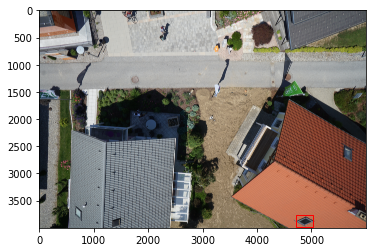

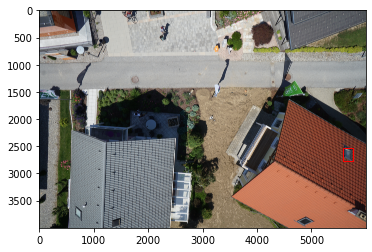

In [36]:
from matplotlib import pyplot as plt
from matplotlib import patches

img, _ = dataset_test[0]
predictions = model([img.to(device)])

for i in range(len(predictions[0]['boxes'])):
    x1, x2, x3, x4 = map(int, predictions[0]['boxes'][i].tolist())
    # print(x1, x2, x3, x4)
    
    fig, ax = plt.subplots()
    ax.imshow(img.mul(255).permute(1, 2, 0).byte().numpy())
    rect = patches.Rectangle((x1, x2), x3-x1, x4-x2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
# cv2_imshow('img', image)

In [34]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [35]:
# Image.fromarray(predictions[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
prediction

[{'boxes': tensor([[4727.5430, 3768.8188, 5034.0132, 3981.7207],
          [5587.6387, 2537.8145, 5762.9839, 2766.0747]], device='cuda:0'),
  'labels': tensor([15, 15], device='cuda:0'),
  'scores': tensor([0.0518, 0.0504], device='cuda:0')}]

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())